# Comportement des isothermes de pression 

Ce script s'intéresse à l'effet d'une transition de phase sur les isothermes de pression. Lorsque l'on passe une transition de phase, les isothermes de pression changent de comportement comme le montre l'image suivante qui plot les isothermes de pression pour un fluide de Van der Waals:
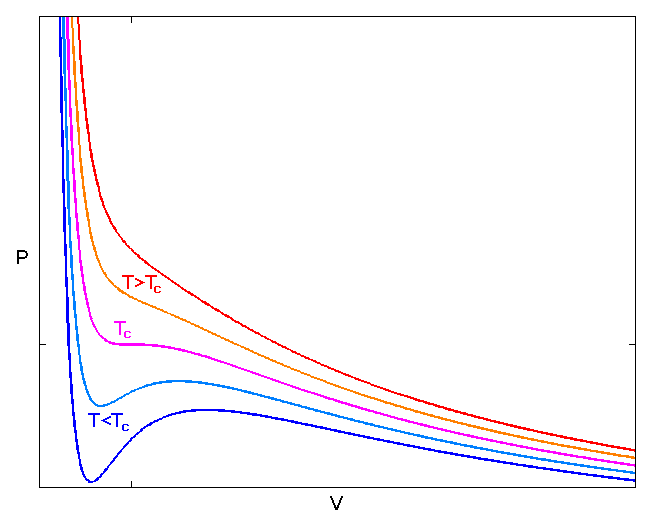

La transition de phase est marquée par l'apparition d'un minimum dans les iso-p. A partir de ce diagramme, il est possible de remonter au diagramme de phase de notre fluide.

## Importation des librairies et des routines

In [2]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import math
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)
from library import *

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

## Balayage en  température pour différents volumes

On souhaite tracer les isothermes dans un diagramme de Clapeyron. Pour celà, on utilise la relation $V=\dfrac{N_\mathrm{particules}}{\rho}$. Ainsi, en faisant varier la densité, on fait varier le volume de l'enceinte. Il ne nous suffit plus que de régler les paramètres de notre simulation

In [67]:
rho_range = np.concatenate((np.arange(0.05,0.125,0.025), np.arange(0.15,0.25,0.05),np.arange(0.25,0.55,0.1),np.arange(0.55,0.75,0.05),np.arange(0.75,0.95,0.025)))
print(rho_range)


[0.05  0.075 0.1   0.15  0.2   0.25  0.35  0.45  0.55  0.55  0.6   0.65
 0.7   0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925]


In [85]:
kT_range = np.array([0.1,0.3,0.5,0.7])
print(kT_range)

[0.1 0.3 0.5 0.7]


In [86]:
#### When in doubt use a small number of particles to speed up the simulations
# In a perfect world (as opposed to an exam), we would generate data for different systems sizes 
# and study finite size effects.

NParticles = 32
m = np.ones(NParticles)
d = 2

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time
print('tau=',tau)

# Not much fun, if we reduce this even further
NTrajectories = 10
run_time_equilibration = 2
run_time_data_acquisition = 3

print("One sweep over all state points corresponds to ", rho_range.size * kT_range.size * NTrajectories," separate simulations!")

# On my computer each of the for "sweeps" below took 2 minutes. If you are worried about time try first with
# NTrajectories = 1

tau= 1.0
One sweep over all state points corresponds to  840  separate simulations!


et de lancer la routine.

In [ ]:
# Create empty dictionaries for the data generated by MD simulations at specific state points
t_tr_ens_from_NVT_heating = {}
x_tr_ens_from_NVT_heating = {}
y_tr_ens_from_NVT_heating = {}
vx_tr_ens_from_NVT_heating = {}
vy_tr_ens_from_NVT_heating = {}
uPot_tr_ens_from_NVT_heating = {}
uKin_tr_ens_from_NVT_heating = {}
pPot_tr_ens_from_NVT_heating = {}
pKin_tr_ens_from_NVT_heating = {}
list_of_starting_configurations_from_NVT_heating = {}


# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

# sweep over densities
for rho in rho_range:
    
    # re-initialize starting configurations
    list_of_starting_configurations=[]
    for n in range(NTrajectories): 
            list_of_starting_configurations.append([])    
    

    # sweep over temperatures
    for kT in kT_range:
        
        print("rho = ",rho,", kT = ",kT)
        
        # Box size
        LBox = np.power(NParticles/rho,1./d)


        # Equilibrate
        # ... reset velocities more often and hope for the best
        (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
         uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
         list_of_starting_configurations
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_equilibration,
                                                                       list_of_starting_configurations=list_of_starting_configurations,
                                                                       number_of_time_steps_between_velocity_resets=10)

        key = (NParticles,str(round(rho,3)),str(round(kT,2)))
        # using floats as key can lead to difficulties, because of their inexact representation
        
                # Generate data
        run_time = 1  # outrageously short
        (t_tr_ens_from_NVT_heating[key], 
         x_tr_ens_from_NVT_heating[key], 
         y_tr_ens_from_NVT_heating[key], 
         vx_tr_ens_from_NVT_heating[key], 
         vy_tr_ens_from_NVT_heating[key],
         uPot_tr_ens_from_NVT_heating[key], 
         uKin_tr_ens_from_NVT_heating[key], 
         pPot_tr_ens_from_NVT_heating[key], 
         pKin_tr_ens_from_NVT_heating[key],
         list_of_starting_configurations_from_NVT_heating[key]
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_data_acquisition,
                                                                       list_of_starting_configurations=list_of_starting_configurations)
        

print("Execution time: ",time.perf_counter() - initialWallTime)

rho =  0.05 , kT =  0.1
rho =  0.05 , kT =  0.3
rho =  0.05 , kT =  0.5


## Tracé des isothermes

On utilise le "trick" consistant à filtrer les dictionnaires

In [75]:
def filterTheDict(dictObj, callback):
    '''
    Iterate over all the keys in dictionary and call the given callback function() on each key. 
    Add items for which callback() returns True to a new dictionary. 
    In the end return the new dictionary.
    '''
    newDict = dict()
    # Iterate over all the items in dictionary
    for key in dictObj.keys():
        # Check if item satisfies the given condition then add to new dict
        if callback(key):
            newDict[key] = dictObj[key]
    return newDict

et on plot les isothermes avec leurs barres d'erreurs.

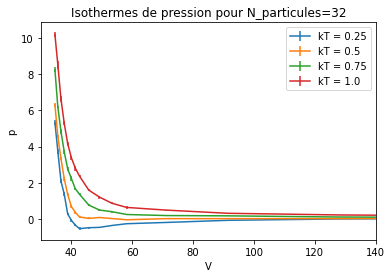

In [80]:
# remember that the keys are stored as strings

# sweep over temperatures
for kT in kT_range:
        
    filtered_pPot_tr_ens = filterTheDict(pPot_tr_ens_from_NVT_heating,lambda key : key[2]==str(round(kT,3)) )
    filtered_pKin_tr_ens = filterTheDict(pKin_tr_ens_from_NVT_heating,lambda key : key[2]==str(round(kT,3)) )
    
    rho_list = []
    p_list = []
    p_error_list = []
    
    for key in sorted(filtered_pPot_tr_ens):
            
        rho_list.append(float(key[1]))
        
        # time average over runs followed by the ensemble average
        p_list.append(
            np.mean(
                np.mean(filtered_pPot_tr_ens[key] +
                        filtered_pKin_tr_ens[key],axis=-1) ) )
        p_error_list.append(
            np.std(
                np.mean(filtered_pPot_tr_ens[key] +
                        filtered_pKin_tr_ens[key],axis=-1) ) / np.sqrt(NTrajectories))
            
    plt.errorbar(NParticles/np.array(rho_list),p_list,yerr=p_error_list,label="kT = "+str(kT))
plt.xlim(30,140)
plt.xlabel("V")
plt.ylabel("p")
plt.title("Isothermes de pression pour N_particules={}".format(NParticles))
plt.legend()

On remarque qu'à $\dfrac{kT}{\varepsilon}=0.25$, la pression admet un minimum ce qui trahit la présence d'une transition de phase.